In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import illustris_python.groupcat as gc
import numpy as np

In [3]:
basePath = "/hpcfs/home/ciencias/fisica/docentes/je.forero/Illustris-1/"

In [18]:
subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr']
subhalos = gc.loadSubhalos(basePath,135,fields=subhalo_fields)

In [19]:
halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub']
halos = gc.loadHalos(basePath, 135, fields=halo_fields)

In [20]:
mass_msun = halos['Group_M_Crit200'] * 1e10 / 0.704
n_in_halo = halos['GroupNsubs']

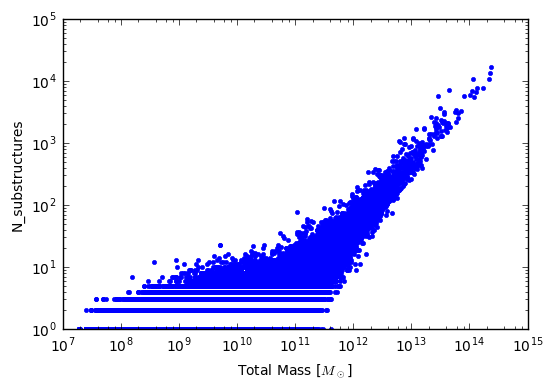

In [105]:
plt.xscale('log')
plt.yscale('log')
plt.plot(mass_msun,n_in_halo, '.')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('N_substructures')

/lustre/apps/anaconda/3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


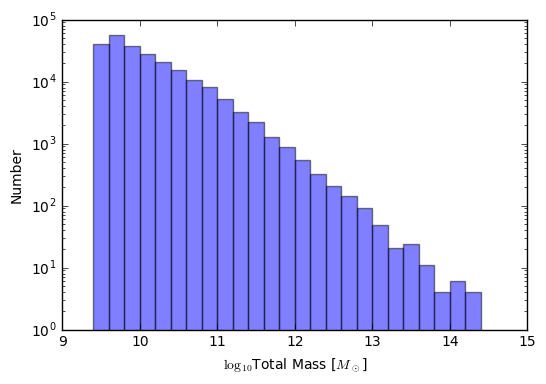

In [132]:
log_mass_msun = np.log10(mass_msun)
mass_limit = log_mass_msun > 9.5
number_limit = n_in_halo > 2

a = plt.hist(log_mass_msun[mass_limit], log=True, bins=np.linspace(9,15.0, 31.0), alpha=0.5, color='blue')
plt.xlabel('$\log_{10}$Total Mass [$M_\odot$]')
plt.ylabel('Number')

In [134]:
mass_sample = np.where(log_mass_msun > 9.5)
mass_sample = mass_sample[0]
n_in_sample = len(mass_sample)
print(n_in_sample)

229675


In [135]:
def get_masses(subhalos, halos, main_group_id=0):
    pos_in = subhalos['SubhaloPos'][subhalos['SubhaloGrNr']==main_group_id]
    vel_in = subhalos['SubhaloVel'][subhalos['SubhaloGrNr']==main_group_id]
    mass_in = subhalos['SubhaloMass'][subhalos['SubhaloGrNr']==main_group_id]
    #plt.scatter(pos_in[:,0], pos_in[:,1], s=0.1)
    vel_in_mag = np.sqrt(vel_in[:,0]**2 + vel_in[:,1]**2 + vel_in[:,2]**2)
    sigma_vel_in_3D = vel_in_mag.std()
    alpha = 2.5
    sigma_vel_p = sigma_vel_in_3D/np.sqrt(alpha)
    virial_mass_group = 2.0E6 * sigma_vel_p**3
    simulation_mass_group = halos['Group_M_Crit200'][main_group_id] * 1e10 / 0.704
    return virial_mass_group, simulation_mass_group

In [136]:
full_id_list = np.arange(n_in_sample, dtype=int)
n_sub_sample = int(n_in_sample/100)
print(n_sub_sample)
sub_sample_id = np.random.choice(full_id_list, size=n_sub_sample)

virial_masses = np.zeros(n_in_sample)
sim_masses = np.zeros(n_in_sample)
for i in range(n_sub_sample):
    virial_masses[i], sim_masses[i] = get_masses(subhalos, halos, main_group_id=sub_sample_id[i])

2296


(1000000000.0, 100000000000000.0)

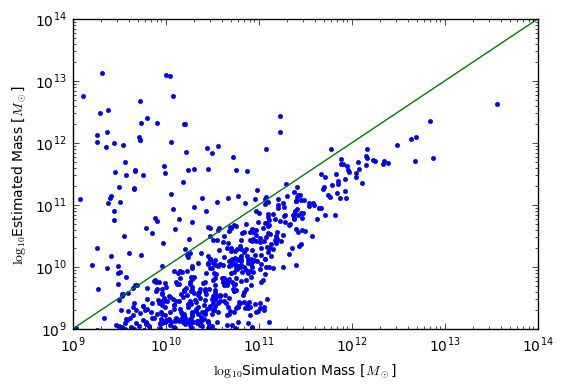

In [137]:
plt.xscale('log')
plt.yscale('log')
plt.plot(sim_masses, virial_masses, '.')
x = np.logspace(8, 14, num=20)
plt.plot(x,x)
plt.xlabel('$\log_{10}$Simulation Mass [$M_\odot$]')
plt.ylabel('$\log_{10}$Estimated Mass [$M_\odot$]')
ax = plt.axes()
ax.set_xlim([1E9, 1E14])
ax.set_ylim([1E9, 1E14])

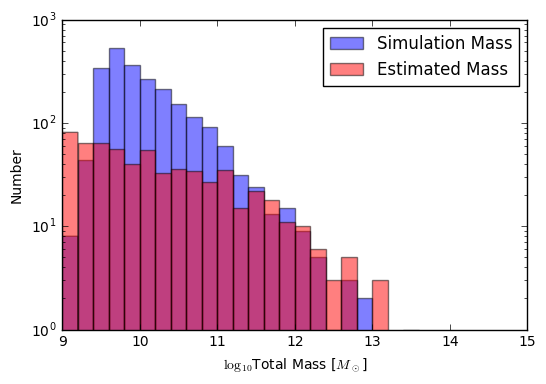

In [143]:
a = plt.hist(np.log10(sim_masses+1.0), log=True, bins=np.linspace(9,15.0, 31.0), alpha=0.5, 
             color='blue', label='Simulation Mass')
a = plt.hist(np.log10(virial_masses+1.0), log=True, bins=np.linspace(9,15.0, 31.0), alpha=0.5, 
             color='red', label='Estimated Mass')
plt.xlabel('$\log_{10}$Total Mass [$M_\odot$]')
plt.ylabel('Number')
plt.legend()